In [1]:
#pip install tf_keras #To avoid keras layers issue during transfer learning

In [2]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt

2024-05-23 15:32:57.597288: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-23 15:32:57.597352: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-23 15:32:57.598878: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
print(tf.__version__)

2.15.0


In [4]:
import os

# Walk through pizza_steak directory and list number of files
for dirpath, dirnames, filenames in os.walk("/kaggle/input/rockpaperscissors/rps-cv-images/"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

There are 3 directories and 1 images in '/kaggle/input/rockpaperscissors/rps-cv-images/'
There are 0 directories and 712 images in '/kaggle/input/rockpaperscissors/rps-cv-images/paper'
There are 0 directories and 726 images in '/kaggle/input/rockpaperscissors/rps-cv-images/rock'
There are 0 directories and 750 images in '/kaggle/input/rockpaperscissors/rps-cv-images/scissors'


In [5]:
import shutil
from random import shuffle
from math import ceil

def split_data_and_copy(source_dir,target_dir,percent_of_train_data):
    os.makedirs(target_dir, exist_ok=True)
        
    train_dir = os.path.join(target_dir,'train')
    test_dir = os.path.join(target_dir,'test')

    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    for subdir, dirs, files in os.walk(source_dir):
        if subdir == source_dir:
            continue
        subdir_name = os.path.basename(subdir)
        train_subdir = os.path.join(train_dir,subdir_name)
        test_subdir = os.path.join(test_dir,subdir_name)

        print(f"- Working on {train_subdir} and {test_subdir}")
        os.makedirs(train_subdir, exist_ok=True)
        os.makedirs(test_subdir, exist_ok=True)

        shuffle(files)
        split_point = ceil(percent_of_train_data * len(files) / 100)

        train_files = files[:split_point]
        test_files = files[split_point:]

        for file in train_files:
            shutil.copy(os.path.join(subdir,file),train_subdir)

        for file in test_files:
            shutil.copy(os.path.join(subdir,file),test_subdir)
            

    print("Images copied successfully.")

In [6]:
split_data_and_copy("/kaggle/input/rockpaperscissors/rps-cv-images/","/kaggle/working/",80)

- Working on /kaggle/working/train/paper and /kaggle/working/test/paper
- Working on /kaggle/working/train/rock and /kaggle/working/test/rock
- Working on /kaggle/working/train/scissors and /kaggle/working/test/scissors
Images copied successfully.


In [7]:
#To remove all directories and images, in case for clean up purposes
# shutil.rmtree("/kaggle/working/test")
# shutil.rmtree("/kaggle/working/train")

In [8]:
# Walk through pizza_steak directory and list number of files
for dirpath, dirnames, filenames in os.walk("/kaggle/working/"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

There are 3 directories and 2 images in '/kaggle/working/'
There are 3 directories and 0 images in '/kaggle/working/train'
There are 0 directories and 744 images in '/kaggle/working/train/scissors'
There are 0 directories and 706 images in '/kaggle/working/train/paper'
There are 0 directories and 722 images in '/kaggle/working/train/rock'
There are 0 directories and 0 images in '/kaggle/working/.virtual_documents'
There are 3 directories and 0 images in '/kaggle/working/test'
There are 0 directories and 366 images in '/kaggle/working/test/scissors'
There are 0 directories and 346 images in '/kaggle/working/test/paper'
There are 0 directories and 361 images in '/kaggle/working/test/rock'


In [9]:
import pathlib
import numpy as np
data_dir = pathlib.Path("/kaggle/working/train") # turn our training path into a Python path
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
print(class_names)

['paper' 'rock' 'scissors']


In [10]:
# View an image
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.figure()
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image
  return img

Image shape: (200, 300, 3)
Image shape: (200, 300, 3)
Image shape: (200, 300, 3)


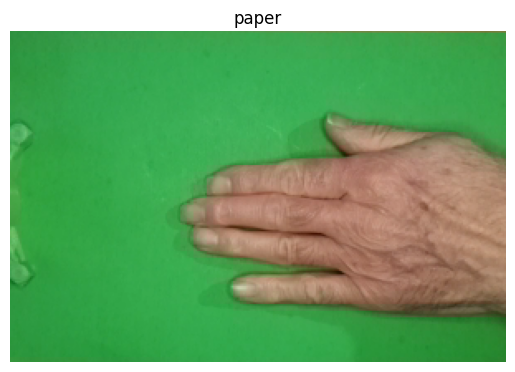

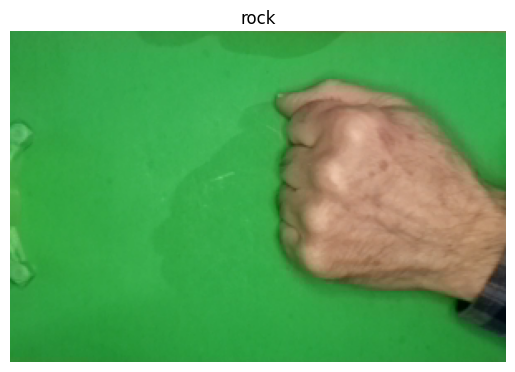

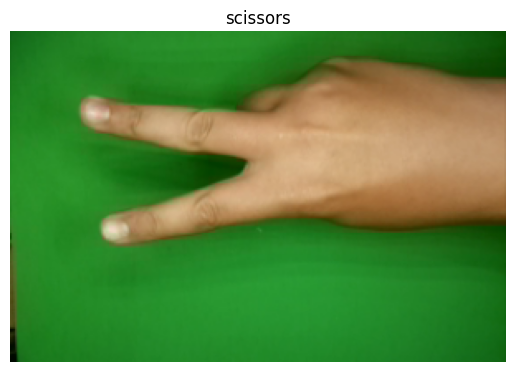

In [11]:
#View a random image from the training dataset
for item in class_names:
    img = view_random_image(target_dir="/kaggle/working/train/",target_class=item)

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Set the seed
tf.random.set_seed(42)

# Preprocess data (get all of the pixel values between 1 and 0, also called scaling/normalization)
train_datagen = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=30, # rotate the image slightly between 0 and 20 degrees (note: this is an int not a float)
                                             shear_range=0.2, # shear the image
                                             zoom_range=0.2, # zoom into the image
                                             width_shift_range=0.2, # shift the image width ways
                                             height_shift_range=0.2, # shift the image height ways
                                             horizontal_flip=True) # flip the 
valid_datagen = ImageDataGenerator(rescale=1./255)

# Setup the train and test directories
train_dir = "/kaggle/working/train"
test_dir = "/kaggle/working/test"

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=32, # number of images to process at a time 
                                               target_size=(224, 224), # convert all images to be 224 x 224
                                               class_mode="categorical", # type of problem we're working on
                                               seed=42,
                                               shuffle=True)

valid_data = valid_datagen.flow_from_directory(test_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="categorical",
                                               seed=42,
                                               shuffle=True)

Found 2172 images belonging to 3 classes.
Found 1073 images belonging to 3 classes.


In [13]:
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

def create_model_checkpoint(model_name,patience=5):
    early_stopping_callback = EarlyStopping(monitor='val_loss', patience=patience)
    checkpoint_callback = ModelCheckpoint(filepath=f"{model_name}.keras", monitor='val_loss', save_best_only=True)
    return [early_stopping_callback,checkpoint_callback]

In [14]:
# Create a CNN model (same as Tiny VGG - https://poloclub.github.io/cnn-explainer/)
model_1 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=32, 
                         kernel_size=3, # can also be (3, 3)
                         activation="relu", 
                         input_shape=(224, 224, 3)), # first layer specifies input shape (height, width, colour channels)
  tf.keras.layers.Conv2D(32, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=2, # pool_size can also be (2, 2)
                            padding="valid"), # padding can also be 'same'
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.Conv2D(10, 3, activation="relu"), # activation='relu' == tf.keras.layers.Activations(tf.nn.relu)
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(len(class_names), activation="softmax") # output
])

# Compile the model
model_1.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])


# Fit the model
history_1 = model_1.fit(train_data,
                        epochs=100,
                        steps_per_epoch=int(len(train_data)/1),
                        validation_data=valid_data,
                        validation_steps=int(len(valid_data)/1),
                        callbacks=create_model_checkpoint(model_name="model_1",patience=10))

Epoch 1/100


I0000 00:00:1716478400.313309    1109 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


68/68 [==============================] - 34s 434ms/step - loss: 1.0661 - accuracy: 0.4507 - val_loss: 0.9588 - val_accuracy: 0.5620
Epoch 2/100
68/68 [==============================] - 29s 429ms/step - loss: 1.0068 - accuracy: 0.4857 - val_loss: 0.9537 - val_accuracy: 0.4595
Epoch 3/100
68/68 [==============================] - 29s 430ms/step - loss: 0.9816 - accuracy: 0.5037 - val_loss: 0.9226 - val_accuracy: 0.5340
Epoch 4/100
68/68 [==============================] - 29s 429ms/step - loss: 0.8629 - accuracy: 0.5787 - val_loss: 0.8217 - val_accuracy: 0.5144
Epoch 5/100
68/68 [==============================] - 29s 426ms/step - loss: 0.7425 - accuracy: 0.6773 - val_loss: 0.7325 - val_accuracy: 0.6785
Epoch 6/100
68/68 [==============================] - 29s 425ms/step - loss: 0.6799 - accuracy: 0.7390 - val_loss: 0.5684 - val_accuracy: 0.7829
Epoch 7/100
68/68 [==============================] - 29s 422ms/step - loss: 0.5659 - accuracy: 0.8099 - val_loss: 0.3053 - val_accuracy: 0.9105
Epoc

In [15]:
best_model_1 =  tf.keras.models.load_model('model_1.keras')
loss,accuracy = best_model_1.evaluate(train_data)
print(f"Model loss on the test set: {loss}")
print(f"Model accuracy on the test set: {100*accuracy:.2f}%")

68/68 [==============================] - 26s 376ms/step - loss: 0.1915 - accuracy: 0.9489
Model loss on the test set: 0.1914624124765396
Model accuracy on the test set: 94.89%


In [16]:
loss,accuracy = best_model_1.evaluate(valid_data)
print(f"Model loss on the test set: {loss}")
print(f"Model accuracy on the test set: {100*accuracy:.2f}%")

34/34 [==============================] - 3s 88ms/step - loss: 0.1011 - accuracy: 0.9795
Model loss on the test set: 0.10110152512788773
Model accuracy on the test set: 97.95%
